In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy                  # http://scipy.org/
from scipy import signal

from IPython.display import Image  
%matplotlib inline
params = {'legend.fontsize': 12,
          'figure.figsize': (10, 10),
         'axes.labelsize': 12,
         'axes.titlesize': 12,
         'xtick.labelsize':12,
         'ytick.labelsize':12}
plt.rcParams.update(params) 

from sympy.solvers import solve

from sympy import Symbol, Function, nsolve 

Se desea un filtro de paso de banda centrado en $250 MHz$ que tenga un ancho de banda de $3dB$ de $40 MHz$. 

-
Además, suponga que el nivel de impedancia del filtro $R_s =200$.

La capacitancia de sintonización requerida es
$$C_t  =   \frac{1}{ \pi  \sqrt{2} R B}$$



Los inductores de resonancia de derivación $_{eff}$ 
$$L_{eff}  =  [\omega C_t  -  \frac{1}{2 R^2 C_t}]^{-1}$$


El inductor de acoplamiento 
$$L_{c}  = \frac{R}{ \omega_c} =127,3 nH.$$
 

El valor para $L_r$ 
$$L_{r}  =  \frac{L_{eff} L_c}{L_c + L_{eff}} = 16.36 nH$$
 
Los divisores capacitivos 

$$C_1  =   \frac{1}{\omega R_S} \sqrt{(\frac{\omega_g}{\omega})^{\gamma}(\frac{R_S}{R_g}) + \omega^2 R_s R_g (\frac{\omega}{\omega_g})^{\gamma} C_t^2 -1}$$

$$C_2  =  [\frac{\omega^2 C_t }{ (\frac{\omega_g}{\omega})^{2\gamma} \frac{1}{R_g^2} + (\omega C_t)^2 } - \frac{\omega^2 R_S^2 C_1 }{1+(\omega R_S C_1)^2}]^{-1}$$

In [2]:
def calcC(w,wg,ro,rg,ct,g ):
    c1 = 1/w/ro*( (wg/w)**g*(ro/rg)+w**2*ro*rg*(w/wg)**g*ct**2-1)**(1/2)
    c2 = ( w**2*ct/(((wg/w)**g/rg)**2+(w*ct)**2 ) - (w**2*c1*ro**2)/(1+(w*ro*c1)**2) )**(-1)
    return c1, c2
  
    
def AvPiE(w,rs,C1,C2,Lc,Lr,rl):
    yl = 1/rl + (w*C1*1j)
    z1 = 1/yl + 1/(w*C2*1j)
    y2 = 1/z1 + 1/(w*Lr*1j)
    z3 = 1/y2 + (w*Lc*1j)
    y4 = 1/z3 + 1/(w*Lr*1j)
    z5 = 1/y4 + 1/(w*C2*1j)
    y6 = 1/z5 + (w*C1*1j)
    zi = 1/y6
    return (abs((zi/(rs+zi))/z5/y4/z3/y2/z1/yl ))    

In [3]:
finf = 80e6
fsup = 120e6


fg = (finf*fsup)**(1/2)
wg = 2*np.pi*fg
B = 5e6
rg = 500
ro = 50
rs = 50
rl = 50
gamma = 1

In [4]:
Lc   = rg/wg
 
Ctg   =  1/(np.pi*2**(1/2)*rg*B)
Leff =   1/(wg**2*Ctg)
Lr   = Leff*Lc/(Leff-Lc)

Cti   = Ctg*(fg/finf)**2

C1i,C2i = calcC(2*np.pi*finf,2*np.pi*fg,ro,rg,Cti,gamma )


Cts   = Ctg*(fg/fsup)**2

C1s,C2s = calcC(2*np.pi*fsup,2*np.pi*fg,ro,rg,Cts,gamma )

print('.param rs =  {:2.1f} '.format(ro) )
print('.param rl =  {:2.1f} '.format(ro) )

print('.param Lc =  {:3.2f}n'.format(Lc/1e-9) )
print('.param Lr =  {:3.2f}n'.format(-Lr/1e-9) )

print('.param C1 =  {:3.3f}p'.format(C1s/1e-12) )
print('.param C2 =  {:3.3f}p'.format(C2s/1e-12) )

print('.param C1 =  {:3.3f}p'.format(C1i/1e-12) )
print('.param C2 =  {:3.3f}p'.format(C2i/1e-12) )


.param rs =  50.0 
.param rl =  50.0 
.param Lc =  812.18n
.param Lr =  30.40n
.param C1 =  208.508p
.param C2 =  83.896p
.param C1 =  384.086p
.param C2 =  207.502p


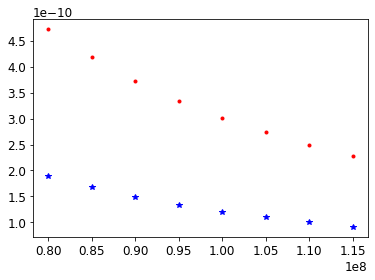

In [5]:
freq = np.arange(80e6,120e6,5e6)


for f in freq:
    Cts   = Ctg*(fg/f)**2

    C1,C2 = calcC(2*np.pi*fsup,2*np.pi*fg,ro,rg,Cts,gamma )

    
    plt.plot(f,C1,'r.')
    plt.plot(f,C2,'b*')
plt.show()    

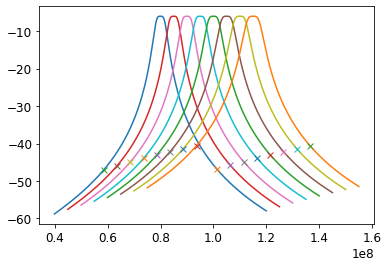

In [7]:
df = np.arange(-40e6,40e6,0.1e6)



for f in freq:
    Cts   = Ctg*(fg/f)**2
    C1,C2 = calcC(2*np.pi*f,2*np.pi*fg,ro,rg,Cts,gamma )    
    plt.plot(f+df,20*np.log10([AvPiE(2*np.pi*(f+fi),rs,C1,C2,Lc,-Lr,rl) for fi in df]))
    plt.plot(f+2*10.7e6,20*np.log10(AvPiE(2*np.pi*(f+2*10.7e6),rs,C1,C2,Lc,-Lr,rl)),'x')
    plt.plot(f-2*10.7e6,20*np.log10(AvPiE(2*np.pi*(f-2*10.7e6),rs,C1,C2,Lc,-Lr,rl)),'x')
plt.show()    